In [1]:
import pandas as pd
import numpy as np
import networkx as nx

# Load the pairwise similarity file
df = pd.read_excel("pairwise_similarity.xlsx")

# Get all unique tweets
tweets = pd.unique(df[["Tweet 1", "Tweet 2"]].values.ravel())

# Create mappings
tweet_to_idx = {tweet: idx for idx, tweet in enumerate(tweets)}
idx_to_tweet = {idx: tweet for tweet, idx in tweet_to_idx.items()}
n = len(tweets)

# Build adjacency matrix using threshold
threshold = 0.32
adj_matrix = np.zeros((n, n))

for _, row in df.iterrows():
    t1, t2, sim = row["Tweet 1"], row["Tweet 2"], row["Similarity Score"]
    if sim >= threshold:
        i, j = tweet_to_idx[t1], tweet_to_idx[t2]
        adj_matrix[i, j] = sim
        adj_matrix[j, i] = sim  # symmetry

# Build graph and compute PageRank
graph = nx.from_numpy_array(adj_matrix)
scores = nx.pagerank(graph)

# Get top 25 ranked tweet indices
top_indices = sorted(scores, key=scores.get, reverse=True)[:25]
summary = [idx_to_tweet[i] for i in top_indices]

# Save summary to an Excel file without header
summary_df = pd.DataFrame(summary)
summary_file = "lexrank_summary_threshold_0.32.xlsx"
summary_df.to_excel(summary_file, index=False, header=False)

print(f"✅ LexRank summary saved to '{summary_file}' (no header row)")


✅ LexRank summary saved to 'lexrank_summary_threshold_0.32.xlsx' (no header row)


🧔 Male Mentions: 10
👩 Female Mentions: 19
📊 Bias Score (female - male): 0.31
🟣 The summary is biased toward females.


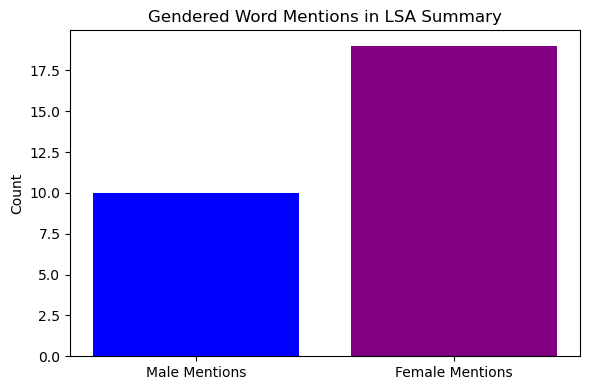

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load summary ===
lsa_summary_df = pd.read_excel("/Users/jessicakamal/lexrank_summary_threshold_0.32.xlsx", header=None)
lsa_summary_text = " ".join(lsa_summary_df[0].astype(str).tolist()).lower()

# === Load gender term lists ===
male_terms = pd.read_csv("/Users/jessicakamal/male_list.csv", header=None)[0].str.lower().tolist()
female_terms = pd.read_csv("/Users/jessicakamal/female_list.csv", header=None)[0].str.lower().tolist()

# === Gender mention counter ===
def count_gender_terms(text, male_terms, female_terms):
    words = text.lower().split()
    male_count = sum(word in male_terms for word in words)
    female_count = sum(word in female_terms for word in words)
    return male_count, female_count

# === Count and calculate bias ===
male_count, female_count = count_gender_terms(lsa_summary_text, male_terms, female_terms)
total = male_count + female_count

if total > 0:
    male_ratio = male_count / total
    female_ratio = female_count / total
    bias_score = female_ratio - male_ratio
else:
    male_ratio = female_ratio = bias_score = 0

# === Results ===
print(f"🧔 Male Mentions: {male_count}")
print(f"👩 Female Mentions: {female_count}")
print(f"📊 Bias Score (female - male): {bias_score:.2f}")

if bias_score > 0:
    print("🟣 The summary is biased toward females.")
elif bias_score < 0:
    print("🔵 The summary is biased toward males.")
else:
    print("⚪ The summary appears neutral.")

# === Plot ===
plt.figure(figsize=(6, 4))
plt.bar(['Male Mentions', 'Female Mentions'], [male_count, female_count], color=['blue', 'purple'])
plt.title('Gendered Word Mentions in LSA Summary')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
